In [2]:
!pip install tensorflow

In [4]:
!pip install scikit-image
!pip install opencv2
!pip install imageio
# !pip install pydot
!pip3 install opencv-python

     |████████████████████████████████| 14.0 MB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 29.7 MB/s eta 0:00:01
     |████████████████████████████████| 195 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 34.4 MB/s eta 0:00:01
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

imageio 2.19.3 requires pillow>=8.3.2, but you'll have pillow 8.0.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement opencv2 (from versions: none)
ERROR: No matching distribution found for opencv2
     |████████████████████████████████| 3.1 MB 17.2 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing instal

In [5]:
import tensorflow as tf

import os

import pandas as pd

import matplotlib.image as mpimg

from PIL import Image
""
import matplotlib.pyplot as plt

from skimage import io

from PIL import ImageFile


In [7]:
total_path = "/notebooks/AI_for_Medicine/Diabetic_Retinopathy/Train/train-trimed-460/"
train_csv = pd.read_csv("/notebooks/AI_for_Medicine/Image_Quality_Assessment/new_label.csv")
test_csv = pd.read_csv("/notebooks/AI_for_Medicine/Image_Quality_Assessment/EyeQ/data/Label_EyeQ_test.csv")


In [10]:
train_image_path="/notebooks/AI_for_Medicine/Image_Quality_Assessment/Train_Images" 
images = os.listdir(train_image_path)
len(images)

12543

In [72]:
good_images = os.listdir("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Images/good/")
usable_images = os.listdir("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Images/usable/")
reject_images = os.listdir("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Images/reject/")

In [17]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.utils import dataset_utils
from keras.utils import image_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [37]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/notebooks/AI_for_Medicine/Image_Quality_Assessment/Images/",
  validation_split=0.2,
  subset="training",
  color_mode='rgb',
  seed=42,
  image_size=(224,224),
  batch_size=32
)

Found 12541 files belonging to 3 classes.
Using 10033 files for training.


In [38]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/notebooks/AI_for_Medicine/Image_Quality_Assessment/Images/",
  validation_split=0.2,
  subset="validation",
  color_mode='rgb',
  seed=42,
  image_size=(224, 224),
  batch_size=32
)

Found 12541 files belonging to 3 classes.
Using 2508 files for validation.


In [39]:
# help(tf.keras.utils.image_dataset_from_directory)

In [40]:
val_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
class_names = train_ds.class_names
print(class_names)


['good', 'reject', 'usable']


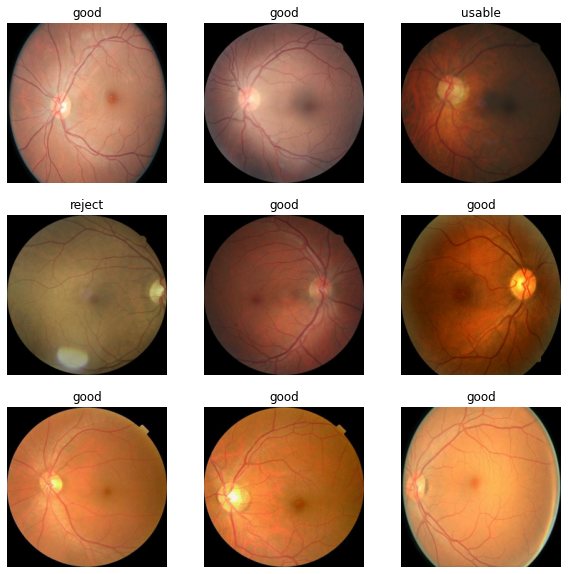

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    

In [43]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)  # shape of a batch of 32 images
    print(labels_batch.shape)
    break
 

(32, 224, 224, 3)
(32,)


In [45]:
image_batch.shape

TensorShape([32, 224, 224, 3])

In [17]:
#Configure the dataset for better performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2)
])

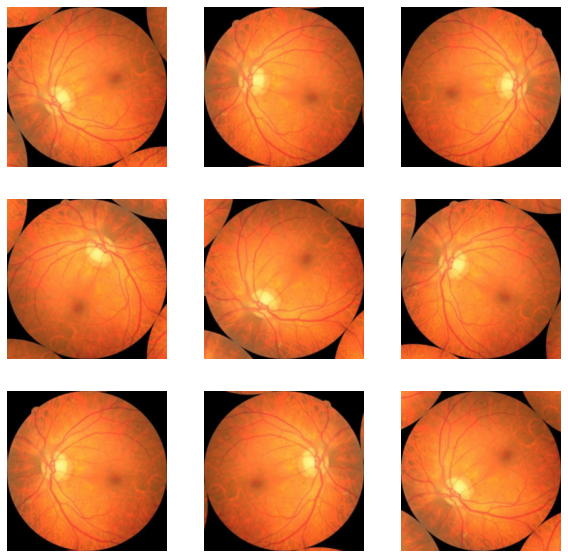

In [19]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[6]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
rescale = tf.keras.layers.Rescaling(
    scale = 1./127.5, offset=-1,
)

# Working with MobileNetV2 Base Model

In [23]:
IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [24]:
# This feature extractor converts each 160x160x3 image into a 7x7x1280 block of features. 
# Let's see what it does to an example batch of images:


image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [25]:
# Feature extraction
# Freezing the convolutional base is setting layers.trainable() to False


base_model.trainable = False

In [26]:
# A look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [33]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [34]:
# Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

keras_callbacks   = [
      EarlyStopping(monitor='loss', patience=30),
      ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1 )
]

In [37]:
# Build a model by chaining together the data augmentation, rescaling,
# base_model and feature extractor layers using the Keras Functional API.
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.



inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [40]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [43]:
# Training the Model

initial_epochs = 20
# validation_steps = 10

loss0, accuracy0 = model.evaluate(val_ds)

79/79 [==============================] - 31s 376ms/step - loss: 1.7009 - accuracy: 0.1734


In [44]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.70
initial accuracy: 0.17


In [45]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    callbacks=keras_callbacks,
                    validation_data=val_ds)

Epoch 1/20
314/314 [==============================] - ETA: 0s - loss: 0.7255 - accuracy: 0.7170
Epoch 1: saving model to training_1/cp.ckpt
314/314 [==============================] - 163s 509ms/step - loss: 0.7255 - accuracy: 0.7170 - val_loss: 0.4895 - val_accuracy: 0.8214
Epoch 2/20
314/314 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8199
Epoch 2: saving model to training_1/cp.ckpt
314/314 [==============================] - 151s 480ms/step - loss: 0.4692 - accuracy: 0.8199 - val_loss: 0.3985 - val_accuracy: 0.8465
Epoch 3/20
314/314 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8426
Epoch 3: saving model to training_1/cp.ckpt
314/314 [==============================] - 150s 478ms/step - loss: 0.4026 - accuracy: 0.8426 - val_loss: 0.3595 - val_accuracy: 0.8600
Epoch 4/20
314/314 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8544
Epoch 4: saving model to training_1/cp.ckpt
314/314 [==========================

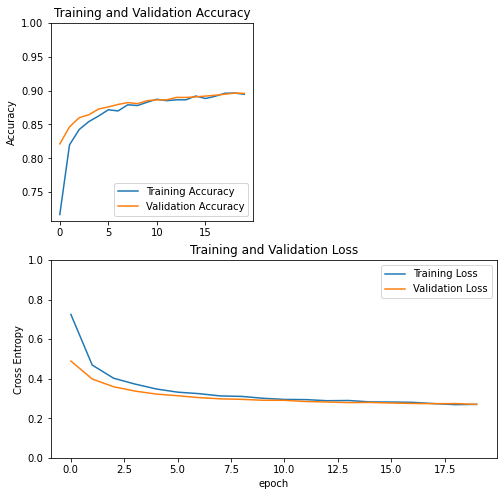

In [46]:
# learning curves of the training and validation accuracy/loss when using theMobileNetV2 base model as a 
# fixed feature extractor.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [47]:
base_model.trainable = True

In [48]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


In [49]:
# compile the model

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [50]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [51]:
# number of weights and biases.

len(model.trainable_variables)

56

In [52]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=keras_callbacks,
                         validation_data=val_ds)

Epoch 20/30
314/314 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8973
Epoch 20: saving model to training_1/cp.ckpt
314/314 [==============================] - 219s 685ms/step - loss: 0.2695 - accuracy: 0.8973 - val_loss: 0.2511 - val_accuracy: 0.9095
Epoch 21/30
314/314 [==============================] - ETA: 0s - loss: 0.2433 - accuracy: 0.9069
Epoch 21: saving model to training_1/cp.ckpt
314/314 [==============================] - 212s 676ms/step - loss: 0.2433 - accuracy: 0.9069 - val_loss: 0.2221 - val_accuracy: 0.9183
Epoch 22/30
314/314 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.9132
Epoch 22: saving model to training_1/cp.ckpt
314/314 [==============================] - 217s 690ms/step - loss: 0.2270 - accuracy: 0.9132 - val_loss: 0.2197 - val_accuracy: 0.9219
Epoch 23/30
314/314 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9208
Epoch 23: saving model to training_1/cp.ckpt
314/314 [==================

In [53]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

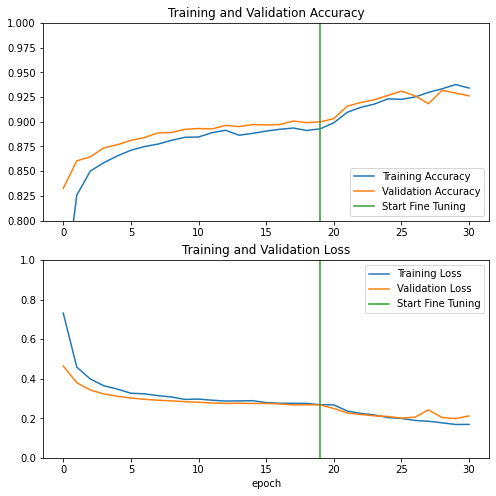

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [54]:
model.save('my_model.h5')

In [10]:
new_model = tf.keras.models.load_model('my_model.h5')

In [8]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [7]:
test_list = os.listdir("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Test_Images/")

In [8]:
test_path = "/notebooks/AI_for_Medicine/Image_Quality_Assessment/Test_Images/"

In [12]:
test_images = test_list[:5]
test_images

['27335_left.jpeg',
 '17104_left.jpeg',
 '36823_right.jpeg',
 '19152_left.jpeg',
 '30394_right.jpeg']

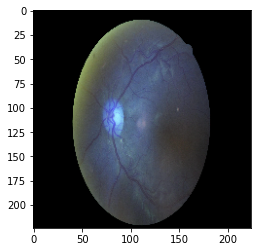

In [74]:
IMG_SIZE = 224
img_array = cv2.imread("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Test_Images/27335_left.jpeg")  
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array/255.0)
plt.show()



In [64]:
image = tf.keras.preprocessing.image.load_img("/notebooks/AI_for_Medicine/Image_Quality_Assessment/Test_Images/27335_left.jpeg", target_size=(224, 224))


In [65]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.



In [66]:
predictions = new_model.predict(input_arr)

1/1 [==============================] - 1s 796ms/step


In [68]:
[np.round(x) for x in predictions]


[array([0., 1., 0.], dtype=float32)]

In [67]:
# predictions

array([[5.5313262e-04, 5.5737311e-01, 4.4207376e-01]], dtype=float32)

In [12]:
LIST = []

In [13]:
for i in test_list:
    image = tf.keras.preprocessing.image.load_img((test_path + i), target_size=(224, 224))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predictions = new_model.predict(input_arr)
    pred_list = [np.round(x) for x in predictions]
    LIST.append(pred_list)
    

1/1 [==============================] - 0s 42ms/step


In [46]:
df.head()

,good,reject,usable,image
0,0.0,1.0,0.0,27335_left.jpeg
1,0.0,0.0,1.0,17104_left.jpeg
2,0.0,0.0,1.0,36823_right.jpeg
3,1.0,0.0,0.0,19152_left.jpeg
4,1.0,0.0,0.0,30394_right.jpeg


In [43]:
predict1.head(20)

,image,good,reject,usable,quality
0,1_right.jpeg,0.0,1.0,0.0,2
1,10001_right.jpeg,1.0,0.0,0.0,0
2,10004_right.jpeg,1.0,0.0,0.0,0
3,10008_left.jpeg,1.0,0.0,0.0,0
4,10016_right.jpeg,1.0,0.0,0.0,0
5,10026_left.jpeg,1.0,0.0,0.0,0
6,10026_right.jpeg,1.0,0.0,0.0,0
7,1003_left.jpeg,0.0,0.0,1.0,1
8,10033_left.jpeg,1.0,0.0,0.0,0
9,10033_right.jpeg,1.0,0.0,0.0,0


In [46]:
confusion_df = pd.crosstab(predict.predicted, predict.actual)

In [47]:
confusion_df

actual,0,1,2
predicted,,,
0,7997,895,33
1,386,2646,188
2,88,1017,2999


<AxesSubplot:xlabel='actual', ylabel='predicted'>

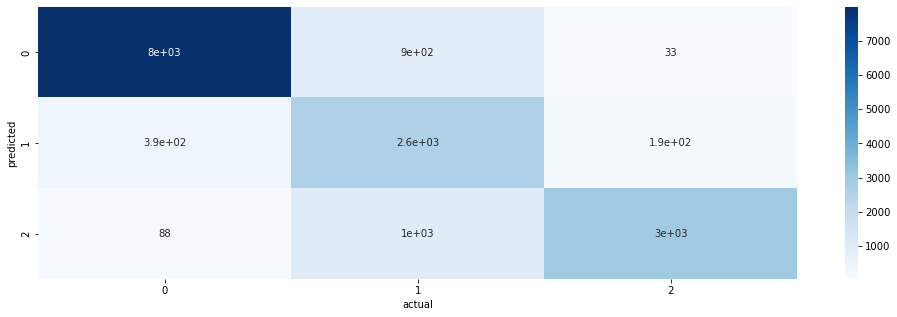

In [58]:
!pip install seaborn
import seaborn as sn
fig = plt.figure(figsize = (17,5))
sn.heatmap(confusion_df,annot=True,cmap='Blues')

In [86]:
# For class zero against the other classes:
TP = confusion_df.iloc[0,0]
FP = confusion_df.iloc[0,:].sum()-TP
FN = confusion_df.iloc[:,0].sum() - TP
TN = correct_pred - (TP+FP+FN)
print(f"TP for class zero is {TP}")
print(f"TN for class zero is {TN}")
print(f"FP for class zero is {FP}")
print(f"FN for class zero is {FN}")

accuracy =  (TP+TP)/total_pred
print(f"Accuracy for class zero is {accuracy}")

precision = TP/(TP+FP)
print(f"Precision for class zero is {precision}")

sensitivity = TP/(TP+FN)
print(f"Sensitivity for class zero is {sensitivity}")

specificity = TN/(FP+TN)
print(f"Specificity for class zero is {specificity}")


TP for class zero is 7997
TN for class zero is 4243
FP for class zero is 928
FN for class zero is 474
Accuracy for class zero is 0.9843067265677888
Precision for class zero is 0.8960224089635854
Sensitivity for class zero is 0.9440443867312006
Specificity for class zero is 0.8205376136143879


In [105]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(predict.actual,predict.predicted,output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.896022,0.821739,0.730750,0.839559,0.816171,0.842434
recall,0.944044,0.580518,0.931366,0.839559,0.818643,0.839559
f1-score,0.919407,0.680381,0.818951,0.839559,0.806246,0.832451
support,8471.000000,4558.000000,3220.000000,0.839559,16249.000000,16249.000000


In [108]:
acc = sklearn.metrics.accuracy_score(predict.actual,predict.predicted)

In [109]:
acc

0.839559357498923